<a href="https://colab.research.google.com/github/LamuGit/FinText-Data/blob/main/Another_copy_of_Copy_of_Random_Forest_Meta_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 6.0 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.3 MB/s eta 0:00:00
MSE: 0.0004, MAE: 0.0044, R2: 0.9906


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.18811),
             ('AMZN', 0.13489),
             ('BAC', 0.06745),
             ('BHP', 0.0672),
             ('CSCO', 0.0619),
             ('JPM', 0.07607),
             ('MSFT', 0.13262),
             ('ORCL', 0.08512),
             ('PEP', 0.03275),
             ('TSLA', 0.15388)])

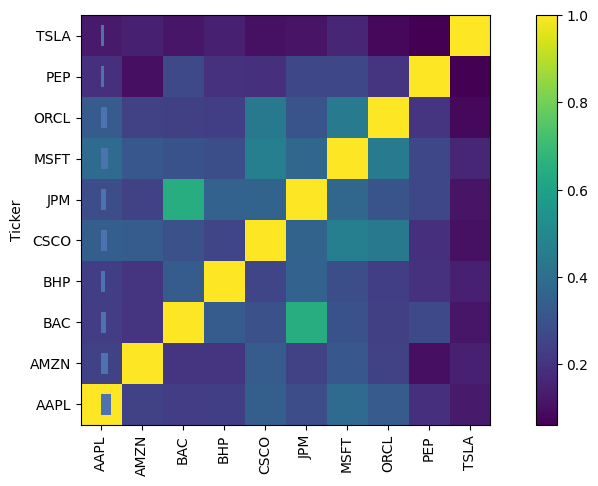

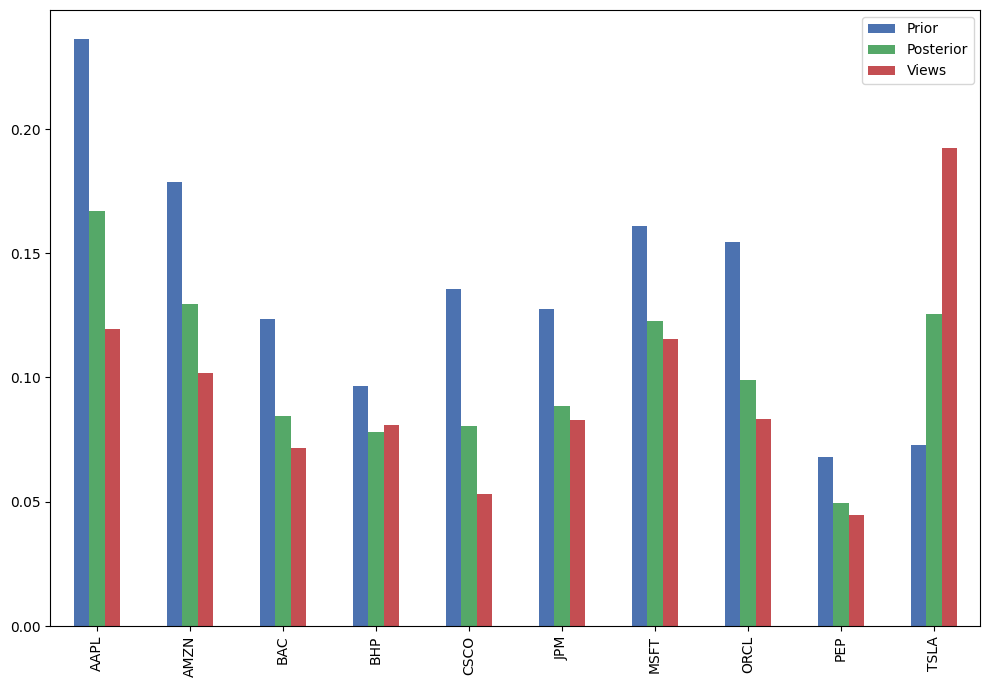

In [ ]:
!pip install xlsxwriter
!pip install pip install PyPortfolioOpt
!pip install cvxpy
!pip install PyPortfolioOpt
import pandas as pd
from xlsxwriter import Workbook
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
#import PyPortfolioOpt
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier
from pypfopt import EfficientFrontier, objective_functions



# Load the files
df1 = pd.read_excel('/Extracted_data_sentiment_Lamu_FinBert_ProsusAI.xlsx')
df2 = pd.read_excel('/Extracted_data_sentiment_Lamu_Finbert_yiyanghkust.xlsx')
df3 = pd.read_excel('/Extracted_data_sentiment_Lamu_distilroberta_mrm8488.xlsx')

# Define a function to calculate the sentiment score for each sentence
def calculate_sentiment_score(row):
    sentiment_score = row['Positive Probability'] - row['Negative Probability'] + (row['Neutral Probability'] * 0.5)
    return sentiment_score

# Apply the function to each row of the dataframes
df1['Sentiment Score'] = df1.apply(calculate_sentiment_score, axis=1)
df2['Sentiment Score'] = df2.apply(calculate_sentiment_score, axis=1)
df3['Sentiment Score'] = df3.apply(calculate_sentiment_score, axis=1)

# Rename the column 'Sentiment Score' in df3 to 'Sentiment Score_llm3'
df3 = df3.rename(columns={'Sentiment Score': 'Sentiment Score_llm3'})

# Rename the column 'Sentiment Score' in df1 and df2
df1 = df1.rename(columns={'Sentiment Score': 'Sentiment Score_llm1'})
df2 = df2.rename(columns={'Sentiment Score': 'Sentiment Score_llm2'})

# Merge the dataframes on the Sentence column
merged_df = pd.merge(df1, df2, on='Sentence', how='inner')
merged_df = pd.merge(merged_df, df3, on='Sentence', how='inner')

# Define the feature columns (sentiment scores from each model)
X = merged_df[['Sentiment Score_llm1', 'Sentiment Score_llm2', 'Sentiment Score_llm3']]

# Define the target column (average sentiment score)
y = merged_df[['Sentiment Score_llm1', 'Sentiment Score_llm2', 'Sentiment Score_llm3']].mean(axis=1)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
 'max_depth': [None, 5, 10],
 'min_samples_split': [2, 5, 10]
}

# Perform grid search to find optimal hyperparameters
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Train a Random Forest model on the training data using optimal hyperparameters
rf = RandomForestRegressor(**grid_search.best_params_)
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Evaluate the model using multiple metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

# Save the results to a new spreadsheet
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results_df.to_excel('results.xlsx', index=False, engine='xlsxwriter')

# Save the model performance metrics to a new spreadsheet
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'R2'],
    'Value': [mse, mae, r2]
})
metrics_df.to_excel('metrics.xlsx', index=False, engine='xlsxwriter')

# Use the trained model to make predictions on the entire dataset
merged_df['Meta Model Score'] = rf.predict(X_scaled)

# Save the resulting dataframe to a new spreadsheet
merged_df.to_excel('meta_model_scores_update.xlsx', index=False, engine='xlsxwriter')


###################################################
#get stock prices
##################################################
# Define the stock symbols

# Load the meta model scores
meta_model_scores = pd.read_excel('meta_model_scores_update.xlsx')

# Get the stock codes
stock_codes = meta_model_scores['Stock'].unique()

# Get the top 10 stock codes
top_10_stock_codes = meta_model_scores['Stock'].value_counts().head(10).index

# Create an empty list to store the stock price data
stock_price_data_list = []

# Loop through each stock code and get the stock price data for 2016
for stock_code in top_10_stock_codes:
    ticker = yf.Ticker(stock_code)
    hist = ticker.history(start='2016-01-01', end='2024-07-31')
    hist['Stock'] = stock_code
    hist.reset_index(inplace=True)
    hist.rename(columns={'index': 'Date'}, inplace=True)
    stock_price_data_list.append(hist)

# Concatenate the stock price data into a single DataFrame
stock_price_data = pd.concat(stock_price_data_list)

# Convert 'Date' column to datetime objects with utc=True to handle timezone-aware datetimes
stock_price_data['Date'] = pd.to_datetime(stock_price_data['Date'], utc=True)

# Now convert to timezone-naive if necessary
stock_price_data['Date'] = stock_price_data['Date'].dt.tz_localize(None)

# Save the stock price data to a new Excel file
stock_price_data.to_excel('stock_price_data_2016to2024.xlsx', index=False, engine='xlsxwriter')

###############################################################
#Black-Litterman v1
###############################################################
tickers = top_10_stock_codes.tolist()
#tickers = ["MSFT", "AAPL", "ORCL", "BAC", "JPM", "BHP", "TSLA", "AMZN", "CSCO", "PEP"]
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()
#market prices
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()
#market cap
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

#Black litterman prior
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta
plotting.plot_covariance(S, plot_correlation=True);
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior
market_prior.plot.barh(figsize=(10,5));

#Views
# Map meta model scores to expected returns using a linear transformation for each stock
absolute_return_views = {}
for stock_code in top_10_stock_codes:
    stock_data = stock_price_data[stock_price_data['Stock'] == stock_code]
    stock_returns = stock_data['Close'].pct_change().mean()
    stock_meta_model_scores = meta_model_scores[meta_model_scores['Stock'] == stock_code]['Meta Model Score']
    min_meta_model_score = stock_meta_model_scores.min()
    max_meta_model_score = stock_meta_model_scores.max()
    min_stock_return = stock_returns.min()
    max_stock_return = stock_returns.max()

    # Apply linear transformation
    expected_return = (stock_meta_model_scores.mean() - min_meta_model_score) / (max_meta_model_score - min_meta_model_score) * (max_stock_return - min_stock_return) + min_stock_return
    absolute_return_views[stock_code] = expected_return*100

# Convert absolute return views to a pandas Series
absolute_return_views = pd.Series(absolute_return_views)



#posterior returns
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=absolute_return_views)
ret_bl = bl.bl_returns()
ret_bl

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(absolute_return_views)],
             index=["Prior", "Posterior", "Views"]).T
rets_df
rets_df.plot.bar(figsize=(12,8));

#posterior covariance
S_bl = bl.bl_cov()
S_bl

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights


# New Section

Prices length: 13166
Meta model scores length: 3122
Prices 2016 length: 2171
Meta model scores 2016 length: 0
Quarter: 0
Weights: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Quarter prices: Ticker
AAPL    25.331825
AMZN    29.659500
BAC     11.279770
BHP     15.315759
CSCO    21.731375
JPM     47.066231
MSFT    49.342735
ORCL    35.885338
PEP     81.744896
TSLA    16.466000
Name: 2016-04-04 00:00:00, dtype: float64
BL Portfolio performance: 32.574093420886996
Equally weighted performance: 33.38234281539918
Cap-weighted performance: 30.164103736655573
Quarter: 63
Weights: OrderedDict([('AAPL', 0.12558), ('AMZN', 0.10991), ('BAC', 0.08793), ('BHP', 0.09084), ('CSCO', 0.08787), ('JPM', 0.09134), ('MSFT', 0.10987), ('ORCL', 0.09338), ('PEP', 0.08306), ('TSLA', 0.12021)])
Quarter prices: Ticker
AAPL    21.992958
AMZN    36.284000
BAC     10.974557
BHP     17.768015
CSCO    22.241072
JPM     49.083153
MSFT    45.860203
ORCL    35.966747
PEP     83.793686
TSLA    14.433333
Name: 2016-0

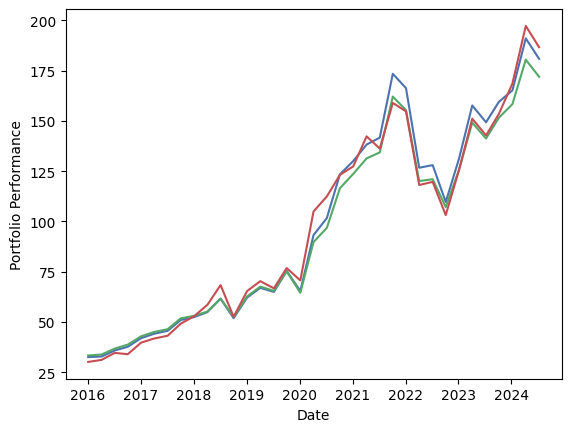

In [ ]:
def quarterly_rebalancing(prices, meta_model_scores, market_prior, S, mcaps):
    print("Prices length:", len(prices))
    print("Meta model scores length:", len(meta_model_scores))

    # Filter the data to only consider the data from 2016 onwards
    prices_2016 = prices[prices.index >= '2016-01-01']
    meta_model_scores.index = pd.to_datetime(meta_model_scores.index)
    meta_model_scores_2016 = meta_model_scores[meta_model_scores.index >= '2016-01-01']

    print("Prices 2016 length:", len(prices_2016))
    print("Meta model scores 2016 length:", len(meta_model_scores_2016))

    # Initialize the portfolio weights
    weights = [1/len(tickers) for _ in tickers]

    # Initialize the portfolio performance
    portfolio_performance = []

    # Initialize the equally weighted portfolio performance
    equally_weighted_performance = []

    # Initialize the cap-weighted portfolio performance
    cap_weighted_performance = []

    # Iterate over the quarters
    for quarter in range(0, len(prices_2016), 63):
        print("Quarter:", quarter)

        # Get the prices for the current quarter
        quarter_prices = prices_2016.iloc[quarter:quarter+63]

        # Get the meta model scores for the current quarter
        quarter_meta_model_scores = meta_model_scores_2016.iloc[quarter:quarter+63]

        print("Weights:", weights)
        print("Quarter prices:", quarter_prices.iloc[-1])

        # Map meta model scores to expected returns using a linear transformation for each stock
        absolute_return_views = {}
        for stock_code in top_10_stock_codes:
            stock_data = stock_price_data[stock_price_data['Stock'] == stock_code]
            stock_returns = stock_data['Close'].pct_change().mean()
            stock_meta_model_scores = quarter_meta_model_scores[quarter_meta_model_scores['Stock'] == stock_code]['Meta Model Score']

            if stock_meta_model_scores.empty:
                # If there is no data for meta_model_scores, set expected return to mean return
                expected_return = stock_returns.mean() * 100
            else:
                min_meta_model_score = stock_meta_model_scores.min()
                max_meta_model_score = stock_meta_model_scores.max()
                min_stock_return = stock_returns.min()
                max_stock_return = stock_returns.max()

                # Apply linear transformation
                expected_return = (stock_meta_model_scores.mean() - min_meta_model_score) / (max_meta_model_score - min_meta_model_score) * (max_stock_return - min_stock_return) + min_stock_return
                expected_return = expected_return * 100

            absolute_return_views[stock_code] = expected_return

        # Convert absolute return views to a pandas Series
        absolute_return_views = pd.Series(absolute_return_views)

        # Calculate posterior weights using market_prior, S, and mcaps
        bl = BlackLittermanModel(S, pi=market_prior, absolute_views=absolute_return_views)
        ret_bl = bl.bl_returns()
        S_bl = bl.bl_cov()
        ef = EfficientFrontier(ret_bl, S_bl)
        ef.add_objective(objective_functions.L2_reg)
        ef.max_quadratic_utility()
        weights = ef.clean_weights()

        # Calculate the BL portfolio performance for the current quarter
        portfolio_performance.append(np.sum(pd.Series(weights) * pd.Series(quarter_prices.iloc[-1])))

        print("BL Portfolio performance:", portfolio_performance[-1])

        # Calculate the equally weighted portfolio performance for the current quarter
        equally_weighted_performance.append(np.sum([1/len(tickers) for _ in tickers] * pd.Series(quarter_prices.iloc[-1])))

        print("Equally weighted performance:", equally_weighted_performance[-1])

        # Calculate the cap-weighted portfolio performance for the current quarter
        cap_weighted_performance.append(np.sum([mcaps[ticker] / sum(mcaps.values()) for ticker in tickers] * pd.Series(quarter_prices.iloc[-1])))

        print("Cap-weighted performance:", cap_weighted_performance[-1])

    # Plot the portfolio performance graph
    dates = prices_2016.index[::63]  # Get the dates for every quarter
    plt.plot(dates, portfolio_performance, label='Black-Litterman Portfolio')
    plt.plot(dates, equally_weighted_performance, label='Equally Weighted Portfolio')
    plt.plot(dates, cap_weighted_performance, label='Cap-Weighted Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Performance')
    plt

    # Call the function with the required arguments
quarterly_rebalancing(prices, meta_model_scores, market_prior, S, mcaps)

Prices length: 13166
Meta model scores length: 3122
Prices 2016 length: 2171
Meta model scores 2016 length: 0
Quarter: 0


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 32.93022572095871
Equally weighted performance: 33.38234281539918
Cap-weighted performance: 30.164103736655573
Quarter: 63



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 32.81576285060883
Equally weighted performance: 33.839772415161136
Cap-weighted performance: 31.17247287530737
Quarter: 126


BL Portfolio performance: 35.093761446809765
Equally weighted performance: 36.79117555618287
Cap-weighted performance: 34.64133642453096
Quarter: 189


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 37.311603157062535
Equally weighted performance: 38.766275787353514
Cap-weighted performance: 34.0105229479355
Quarter: 252



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 39.67708238954544
Equally weighted performance: 42.89705791473389
Cap-weighted performance: 39.75262247542328
Quarter: 315



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 42.87150491600037
Equally weighted performance: 45.082480621337886
Cap-weighted performance: 41.81929555924248
Quarter: 378



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 43.19688000001908
Equally weighted performance: 46.428992462158206
Cap-weighted performance: 43.1727058629586
Quarter: 441



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 53.33915577526093
Equally weighted performance: 51.811204338073736
Cap-weighted performance: 49.15454300144868
Quarter: 504



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 52.85793275201798
Equally weighted performance: 53.073682975769046
Cap-weighted performance: 52.854226560827165
Quarter: 567



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 54.43504168344497
Equally weighted performance: 55.21105079650879
Cap-weighted performance: 58.52668811549369
Quarter: 630



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 57.1288190499115
Equally weighted performance: 61.613336563110344
Cap-weighted performance: 68.37279706530005
Quarter: 693



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 52.55086566768646
Equally weighted performance: 52.51023502349854
Cap-weighted performance: 52.594270011736725
Quarter: 756



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 63.172409778728486
Equally weighted performance: 62.70807876586914
Cap-weighted performance: 65.39656223626017
Quarter: 819



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 65.77517501742363
Equally weighted performance: 67.61015462875366
Cap-weighted performance: 70.31109004010327
Quarter: 882



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 65.14845707683564
Equally weighted performance: 65.47665224075318
Cap-weighted performance: 66.73650502247618
Quarter: 945



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 75.14860207954408
Equally weighted performance: 75.16951026916504
Cap-weighted performance: 76.82254919125847
Quarter: 1008



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 67.25431033205032
Equally weighted performance: 64.5424976348877
Cap-weighted performance: 70.67004113598007
Quarter: 1071



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 100.20429506553653
Equally weighted performance: 89.71100215911866
Cap-weighted performance: 104.917742782445
Quarter: 1134



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 119.3950869262123
Equally weighted performance: 96.8241491317749
Cap-weighted performance: 112.42273254551546
Quarter: 1197



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 141.39022244714738
Equally weighted performance: 116.50126361846925
Cap-weighted performance: 123.12810557749997
Quarter: 1260



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 154.3443335561371
Equally weighted performance: 123.6195671081543
Cap-weighted performance: 127.36861493556232
Quarter: 1323



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 155.89354650989532
Equally weighted performance: 131.32746353149417
Cap-weighted performance: 142.29026764343382
Quarter: 1386



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 138.30522541355134
Equally weighted performance: 134.31266975402832
Cap-weighted performance: 136.250828225729
Quarter: 1449



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 213.9667138248062
Equally weighted performance: 162.06417388916014
Cap-weighted performance: 158.90123258002274
Quarter: 1512



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 143.504317414093
Equally weighted performance: 155.30530700683596
Cap-weighted performance: 154.71032569720575
Quarter: 1575



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 100.80525279123306
Equally weighted performance: 120.06754932403564
Cap-weighted performance: 118.11718604216375
Quarter: 1638



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 118.03939162548066
Equally weighted performance: 120.99613533020019
Cap-weighted performance: 119.66485153631248
Quarter: 1701



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 108.70789194755554
Equally weighted performance: 107.12669258117677
Cap-weighted performance: 103.14907213206882
Quarter: 1764



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 141.22536169960023
Equally weighted performance: 125.75926342010499
Cap-weighted performance: 125.61612196139214
Quarter: 1827



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 179.17668225452422
Equally weighted performance: 149.09547004699706
Cap-weighted performance: 151.07919809182818
Quarter: 1890



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 132.00619243743895
Equally weighted performance: 141.2051519393921
Cap-weighted performance: 142.75006988548304
Quarter: 1953



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 177.0567205240631
Equally weighted performance: 151.50103378295898
Cap-weighted performance: 153.37097516289782
Quarter: 2016



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 186.97297346767428
Equally weighted performance: 158.32944564819334
Cap-weighted performance: 168.55774865329855
Quarter: 2079



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 232.66170138053894
Equally weighted performance: 180.41927146911624
Cap-weighted performance: 197.18966449421993
Quarter: 2142


BL Portfolio performance: 170.92133418880462
Equally weighted performance: 171.91599998474123
Cap-weighted performance: 186.60217079753963


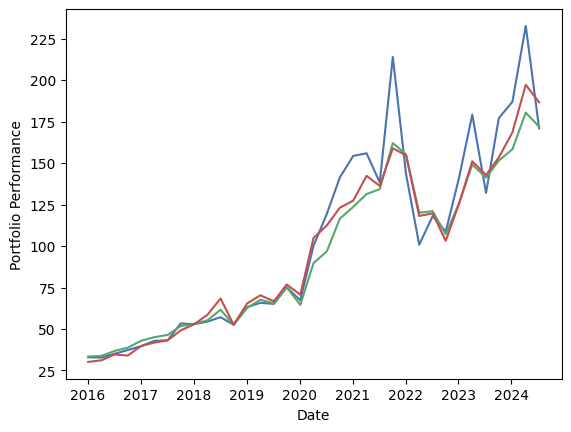

In [ ]:
def quarterly_rebalancing(prices, meta_model_scores, tickers):
    print("Prices length:", len(prices))
    print("Meta model scores length:", len(meta_model_scores))

    # Filter the data to only consider the data from 2016 onwards
    prices_2016 = prices[prices.index >= '2016-01-01']
    meta_model_scores.index = pd.to_datetime(meta_model_scores.index)
    meta_model_scores_2016 = meta_model_scores[meta_model_scores.index >= '2016-01-01']

    print("Prices 2016 length:", len(prices_2016))
    print("Meta model scores 2016 length:", len(meta_model_scores_2016))

    # Initialize the portfolio weights
    weights = [1/len(tickers) for _ in tickers]

    # Initialize the portfolio performance
    portfolio_performance = []

    # Initialize the equally weighted portfolio performance
    equally_weighted_performance = []

    # Initialize the cap-weighted portfolio performance
    cap_weighted_performance = []

    # Iterate over the quarters
    for quarter in range(0, len(prices_2016), 63):
        print("Quarter:", quarter)

        # Get the prices for the current quarter
        quarter_prices = prices_2016.iloc[quarter:quarter+63]

        # Get the meta model scores for the current quarter
        quarter_meta_model_scores = meta_model_scores_2016.iloc[quarter:quarter+63]

        # Update market_prior, S, and mcaps for the current quarter
        market_prices = yf.download("SPY", start=quarter_prices.index[0], end=quarter_prices.index[-1])["Adj Close"]
        delta = black_litterman.market_implied_risk_aversion(market_prices)
        S = risk_models.CovarianceShrinkage(quarter_prices).ledoit_wolf()
        mcaps = {}
        for t in tickers:
            stock = yf.Ticker(t)
            mcaps[t] = stock.info["marketCap"]
        market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

        # Map meta model scores to expected returns using a linear transformation for each stock
        absolute_return_views = {}
        for stock_code in tickers:
            stock_data = stock_price_data[stock_price_data['Stock'] == stock_code]
            stock_returns = stock_data['Close'].pct_change().mean()
            stock_meta_model_scores = quarter_meta_model_scores[quarter_meta_model_scores['Stock'] == stock_code]['Meta Model Score']

            if stock_meta_model_scores.empty:
                # If there is no data for meta_model_scores, set expected return to mean return
                expected_return = stock_returns.mean() * 100
            else:
                min_meta_model_score = stock_meta_model_scores.min()
                max_meta_model_score = stock_meta_model_scores.max()
                min_stock_return = stock_returns.min()
                max_stock_return = stock_returns.max()

                # Apply linear transformation
                expected_return = (stock_meta_model_scores.mean() - min_meta_model_score) / (max_meta_model_score - min_meta_model_score) * (max_stock_return - min_stock_return) + min_stock_return
                expected_return = expected_return * 100

            absolute_return_views[stock_code] = expected_return

        # Convert absolute return views to a pandas Series
        absolute_return_views = pd.Series(absolute_return_views)

        # Calculate posterior weights using market_prior, S, and mcaps
        bl = BlackLittermanModel(S, pi=market_prior, absolute_views=absolute_return_views)
        ret_bl = bl.bl_returns()
        S_bl = bl.bl_cov()
        ef = EfficientFrontier(ret_bl, S_bl)
        ef.add_objective(objective_functions.L2_reg)
        ef.max_quadratic_utility()
        quarter_weights = ef.clean_weights()

        # Calculate the portfolio performance for the current quarter
        portfolio_performance.append(np.sum(pd.Series(quarter_weights) * pd.Series(quarter_prices.iloc[-1])))

        print("BL Portfolio performance:", portfolio_performance[-1])

        # Calculate the equally weighted portfolio performance for the current quarter
        equally_weighted_performance.append(np.sum([1/len(tickers) for _ in tickers] * pd.Series(quarter_prices.iloc[-1])))

        print("Equally weighted performance:", equally_weighted_performance[-1])

        # Calculate the cap-weighted portfolio performance for the current quarter
        cap_weighted_performance.append(np.sum([mcaps[ticker] / sum(mcaps.values()) for ticker in tickers] * pd.Series(quarter_prices.iloc[-1])))

        print("Cap-weighted performance:", cap_weighted_performance[-1])

    # Plot the portfolio performance graph
    dates = prices_2016.index[::63]  # Get the dates for every quarter
    plt.plot(dates, portfolio_performance, label='Black-Litterman Portfolio')
    plt.plot(dates, equally_weighted_performance, label='Equally Weighted Portfolio')
    plt.plot(dates, cap_weighted_performance, label='Cap-Weighted Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Performance')
    plt

    # Call the function with the required arguments
quarterly_rebalancing(prices, meta_model_scores, tickers)

[*********************100%%**********************]  1 of 1 completed

Prices length: 13166
Meta model scores length: 3122
Prices 2016 length: 2171
Meta model scores 2016 length: 0
Quarter: 0



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 32.93022572095871
Equally weighted performance: 33.38234281539918
Cap-weighted performance: 30.164103736655573
Quarter: 63



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 32.81576285060883
Equally weighted performance: 33.839772415161136
Cap-weighted performance: 31.17247287530737
Quarter: 126



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 35.093761446809765
Equally weighted performance: 36.79117555618287
Cap-weighted performance: 34.64133642453096
Quarter: 189



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 37.311603157062535
Equally weighted performance: 38.766275787353514
Cap-weighted performance: 34.0105229479355
Quarter: 252



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 39.67708238954544
Equally weighted performance: 42.89705791473389
Cap-weighted performance: 39.75262247542328
Quarter: 315



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 42.87150491600037
Equally weighted performance: 45.082480621337886
Cap-weighted performance: 41.81929555924248
Quarter: 378



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 43.19688000001908
Equally weighted performance: 46.428992462158206
Cap-weighted performance: 43.1727058629586
Quarter: 441



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 53.33915577526093
Equally weighted performance: 51.811204338073736
Cap-weighted performance: 49.15454300144868
Quarter: 504



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 52.85793275201798
Equally weighted performance: 53.073682975769046
Cap-weighted performance: 52.854226560827165
Quarter: 567



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 54.43504168344497
Equally weighted performance: 55.21105079650879
Cap-weighted performance: 58.52668811549369
Quarter: 630



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 57.1288190499115
Equally weighted performance: 61.613336563110344
Cap-weighted performance: 68.37279706530005
Quarter: 693



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 52.55086566768646
Equally weighted performance: 52.51023502349854
Cap-weighted performance: 52.594270011736725
Quarter: 756



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 63.172409778728486
Equally weighted performance: 62.70807876586914
Cap-weighted performance: 65.39656223626017
Quarter: 819



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 65.77517501742363
Equally weighted performance: 67.61015462875366
Cap-weighted performance: 70.31109004010327
Quarter: 882



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 65.14845707683564
Equally weighted performance: 65.47665224075318
Cap-weighted performance: 66.73650502247618
Quarter: 945



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 75.14860207954408
Equally weighted performance: 75.16951026916504
Cap-weighted performance: 76.82254919125847
Quarter: 1008



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 67.25431033205032
Equally weighted performance: 64.5424976348877
Cap-weighted performance: 70.67004113598007
Quarter: 1071



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 100.20429506553653
Equally weighted performance: 89.71100215911866
Cap-weighted performance: 104.917742782445
Quarter: 1134



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 119.3950869262123
Equally weighted performance: 96.8241491317749
Cap-weighted performance: 112.42273254551546
Quarter: 1197



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 141.39022244714738
Equally weighted performance: 116.50126361846925
Cap-weighted performance: 123.12810557749997
Quarter: 1260



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 154.3443335561371
Equally weighted performance: 123.6195671081543
Cap-weighted performance: 127.36861493556232
Quarter: 1323



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 155.89354650989532
Equally weighted performance: 131.32746353149417
Cap-weighted performance: 142.29026764343382
Quarter: 1386



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 138.30522541355134
Equally weighted performance: 134.31266975402832
Cap-weighted performance: 136.250828225729
Quarter: 1449



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 213.9667138248062
Equally weighted performance: 162.06417388916014
Cap-weighted performance: 158.90123258002274
Quarter: 1512



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 143.504317414093
Equally weighted performance: 155.30530700683596
Cap-weighted performance: 154.71032569720575
Quarter: 1575



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 100.80525279123306
Equally weighted performance: 120.06754932403564
Cap-weighted performance: 118.11718604216375
Quarter: 1638



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 118.03939162548066
Equally weighted performance: 120.99613533020019
Cap-weighted performance: 119.66485153631248
Quarter: 1701



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 108.70789194755554
Equally weighted performance: 107.12669258117677
Cap-weighted performance: 103.14907213206882
Quarter: 1764



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 141.22536169960023
Equally weighted performance: 125.75926342010499
Cap-weighted performance: 125.61612196139214
Quarter: 1827



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 179.17668225452422
Equally weighted performance: 149.09547004699706
Cap-weighted performance: 151.07919809182818
Quarter: 1890



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 132.00619243743895
Equally weighted performance: 141.2051519393921
Cap-weighted performance: 142.75006988548304
Quarter: 1953



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 177.0567205240631
Equally weighted performance: 151.50103378295898
Cap-weighted performance: 153.37097516289782
Quarter: 2016



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 186.97297346767428
Equally weighted performance: 158.32944564819334
Cap-weighted performance: 168.55774865329855
Quarter: 2079



[*********************100%%**********************]  1 of 1 completed

BL Portfolio performance: 232.66170138053894
Equally weighted performance: 180.41927146911624
Cap-weighted performance: 197.18966449421993
Quarter: 2142


BL Portfolio performance: 170.92133418880462
Equally weighted performance: 171.91599998474123
Cap-weighted performance: 186.60217079753963


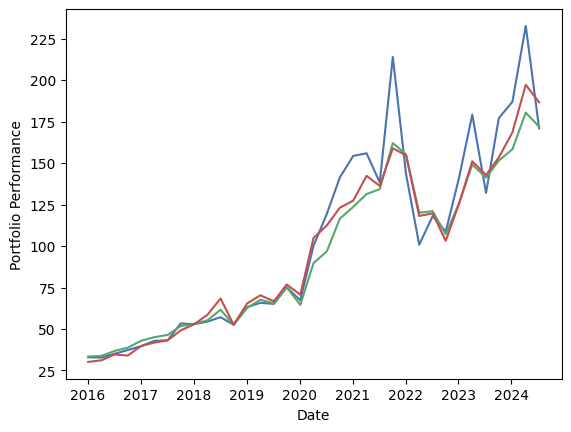

In [ ]:
def weekly_rebalancing(prices, meta_model_scores, tickers):
    print("Prices length:", len(prices))
    print("Meta model scores length:", len(meta_model_scores))

    # Filter the data to only consider the data from 2016 onwards
    prices_2016 = prices[prices.index >= '2016-01-01']
    meta_model_scores.index = pd.to_datetime(meta_model_scores.index)
    meta_model_scores_2016 = meta_model_scores[meta_model_scores.index >= '2016-01-01']

    print("Prices 2016 length:", len(prices_2016))
    print("Meta model scores 2016 length:", len(meta_model_scores_2016))

    # Initialize the portfolio weights
    weights = [1/len(tickers) for _ in tickers]

    # Initialize the portfolio performance
    portfolio_performance = []

    # Initialize the equally weighted portfolio performance
    equally_weighted_performance = []

    # Initialize the cap-weighted portfolio performance
    cap_weighted_performance = []

    # Iterate over the weeks
    for week in range(0, len(prices_2016), 5):
        print("Week:", week)

        # Get the prices for the current week
        week_prices = prices_2016.iloc[week:week+5]

        # Get the meta model scores for the current week
        week_meta_model_scores = meta_model_scores_2016.iloc[week:week+5]

        # Calculate the market_prior, S, and mcaps for the current week
        market_prices = yf.download("SPY", start=week_prices.index[0], end=week_prices.index[-1])["Adj Close"]
        delta = black_litterman.market_implied_risk_aversion(market_prices)
        S = risk_models.CovarianceShrinkage(week_prices).ledoit_wolf()
        mcaps = {}
        for t in tickers:
            stock = yf.Ticker(t)
            mcaps[t] = stock.info["marketCap"]
        market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

        # Map meta model scores to expected returns using a linear transformation for each stock
        absolute_return_views = {}
        for stock_code in tickers:
            stock_data = stock_price_data[stock_price_data['Stock'] == stock_code]
            stock_returns = stock_data['Close'].pct_change().mean()
            stock_meta_model_scores = week_meta_model_scores[week_meta_model_scores['Stock'] == stock_code]['Meta Model Score']

            if stock_meta_model_scores.empty:
                # If there is no data for meta_model_scores, set expected return to mean return
                expected_return = stock_returns.mean() * 100
            else:
                min_meta_model_score = stock_meta_model_scores.min()
                max_meta_model_score = stock_meta_model_scores.max()
                min_stock_return = stock_returns.min()
                max_stock_return = stock_returns.max()

                # Apply linear transformation
                expected_return = (stock_meta_model_scores.mean() - min_meta_model_score) / (max_meta_model_score - min_meta_model_score) * (max_stock_return - min_stock_return) + min_stock_return
                expected_return = expected_return * 100

            absolute_return_views[stock_code] = expected_return

        # Convert absolute return views to a pandas Series
        absolute_return_views = pd.Series(absolute_return_views)

        # Calculate posterior weights using market_prior, S, and mcaps
        bl = BlackLittermanModel(S, pi=market_prior, absolute_views=absolute_return_views)
        ret_bl = bl.bl_returns()
        S_bl = bl.bl_cov()
        ef = EfficientFrontier(ret_bl, S_bl)
        ef.add_objective(objective_functions.L2_reg)
        ef.max_quadratic_utility()
        week_weights = ef.clean_weights()

        # Update the portfolio weights
        weights = week_weights

        # Calculate the portfolio performance for the current week
        portfolio_performance.append(np.sum(pd.Series(weights) * pd.Series(week_prices.iloc[-1])))

        print("BL Portfolio performance:", portfolio_performance[-1])

        # Calculate the equally weighted portfolio performance for the current week
        equally_weighted_performance.append(np.sum([1/len(tickers) for _ in tickers] * pd.Series(week_prices.iloc[-1])))

        print("Equally weighted performance:", equally_weighted_performance[-1])

        # Calculate the cap-weighted portfolio performance for the current week
        cap_weighted_performance.append(np.sum([mcaps[ticker] / sum(mcaps.values()) for ticker in tickers] * pd.Series(week_prices.iloc[-1])))

        print("Cap-weighted performance:", cap_weighted_performance[-1])

    # Plot the portfolio performance graph
    dates = prices_2016.index[::5]
    plt.plot(dates, portfolio_performance, label='Black-Litterman Portfolio')
    plt.plot(dates, equally_weighted_performance, label='Equally Weighted Portfolio')
    plt.plot(dates, cap_weighted_performance, label='Cap-Weighted Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Performance')
    plt

    # Call the function with the required arguments
quarterly_rebalancing(prices, meta_model_scores, tickers)